In [11]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO,ffs
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline

plot.rc.metacolor = 'k'
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight','tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5,'axes.labelweight':'normal',
                'tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33435 instead
  warnings.warn(
/tmp/ipykernel_1700869/1447050377.py:26: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight','tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5,'axes.labelweight':'normal',


In [2]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
enter = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'

maria_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['u'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
divider = np.asarray([maria_u[0][12:].shape[0],maria_u[1][36:].shape[0],maria_u[2][60:].shape[0],maria_u[3][96:].shape[0],maria_u[4][36:].shape[0]]).cumsum()

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
def preproc_pipeline(case='Maria',TYPE='3D' or '2D',suffix=None):
    if case=='Maria':
        filepath = input('Enter Path:')
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Import Preprocessed Flat Data and PCA dictionary
        #------------------------------------------------------------------------------------------------------------------------------------------
        if TYPE=='3D':
            tempdict = {}
            for varname in ['u','v','w','qv','theta','heatsum','hdia','rad','ir']:
                temp = [read_and_proc.depickle(filepath+str(lime)+suffix)[varname] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
                tempdict[varname] = maria_IO.long_MariaExps(temp)
        elif TYPE=='2D':
            tempdict = {}
            for varname in ['u','v','w','qv','theta','heatsum','hdia','rad','ir']:
                temp = [read_and_proc.depickle(filepath+str(lime)+suffix)[varname] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
                tempdict[varname] = maria_IO.long_MariaExps(maria_IO.to_azim(temp))            
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Save to xarray
        #------------------------------------------------------------------------------------------------------------------------------------------
        dims = ['sample','flatarray']
        coords = dict(sample=np.linspace(0,tempdict['u'].shape[0]-1,tempdict['u'].shape[0]),flatarray=np.linspace(0,tempdict['u'].shape[1]-1,tempdict['u'].shape[1]))
        ds = xr.Dataset(coords=coords)
        maria_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','heatsum','hdia','rad','qv','ir'],\
                                                         varfile=[tempdict['u'],tempdict['v'],tempdict['w'],tempdict['theta'],tempdict['heatsum'],tempdict['hdia'],tempdict['rad'],tempdict['qv'],tempdict['ir']],dims=dims,coords=coords)
        del tempdict
        gc.collect()
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Import PCA dictionary
        #------------------------------------------------------------------------------------------------------------------------------------------
        if TYPE=='3D':
            folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/'
            dict1 = read_and_proc.depickle(folderpath+'PCA/PCAdict2')
        elif TYPE=='2D':
            folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/intermediate/'
            dict1 = read_and_proc.depickle(folderpath+'PCA/PCAdict')

        return maria_data, dict1
    
maria_data, dict1 = preproc_pipeline('Maria','2D','_smooth_preproc_dict1b_g')

Enter Path: /work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
def get_surf_azim(expU=None,expV=None,index=None,case='Maria',TYPE='2D' or '3D'):
    if case=='Haiyan':
        if TYPE=='2D':
            surfU_0,surfV_0 = np.asarray(expU[index]).reshape(expU[index].shape[0],10,int(expU[index].shape[1]/10))[:,0,...],np.asarray(expV[index]).reshape(expV[index].shape[0],10,int(expV[index].shape[1]/10))[:,0,...]
            surWSPD_0 = np.max((np.sqrt(surfU_0**2+surfV_0**2)),axis=1)
        elif TYPE=='3D':
            surfU_1,surfV_1 = np.asarray(expU[1]).reshape(expU[1].shape[0],10,360,int(expU[1].shape[1]/10/360))[:,0,...],np.asarray(expV[1]).reshape(expV[1].shape[0],10,360,int(expV[1].shape[1]/10/360))[:,0,...]
            surWSPD_0 = np.max(np.nanmean(np.sqrt(surfU_0**2+surfV_0**2),axis=1),axis=1)
    if case=='Maria':
        if TYPE=='2D':
            surfU_0,surfV_0 = np.asarray(expU[index]).reshape(expU[index].shape[0],39,int(expU[index].shape[1]/39))[:,0,...],np.asarray(expV[index]).reshape(expV[index].shape[0],39,int(expV[index].shape[1]/39))[:,0,...]
            surWSPD_0 = np.max((np.sqrt(surfU_0**2+surfV_0**2)),axis=1)
        elif TYPE=='3D':
            surfU_1,surfV_1 = np.asarray(expU[1]).reshape(expU[1].shape[0],39,360,int(expU[1].shape[1]/39/360))[:,0,...],np.asarray(expV[1]).reshape(expV[1].shape[0],39,360,int(expV[1].shape[1]/39/360))[:,0,...]
            surWSPD_0 = np.max(np.nanmean(np.sqrt(surfU_0**2+surfV_0**2),axis=1),axis=1)
    return surWSPD_0

def _back_to_exp(timeseries=None,divider=None):
    printout = [timeseries[0:divider[0],:]]
    for i in range(1,len(divider)-1):
        printout.append(timeseries[divider[i-1]:divider[i],:])
    printout.append(timeseries[divider[-2]:,:])
    return printout

def get_traj(PCAdict=None,flatdata=None,divider=None,wantvar=None):
    return _back_to_exp(PCAdict[wantvar].transform(flatdata[wantvar].data)[:,0:20],divider)

def normalize(array=None):
    return (array-np.nanmean(array))/np.nanstd(array)

In [34]:
PCtraj_dict={'u':get_traj(dict1,maria_data,divider,'u'),'v':get_traj(dict1,maria_data,divider,'v'),'hdia':get_traj(dict1,maria_data,divider,'hdia'),'rad':get_traj(dict1,maria_data,divider,'rad')}
expU,expV,expQV = _back_to_exp(maria_data['u'],divider),_back_to_exp(maria_data['v'],divider),_back_to_exp(maria_data['qv'],divider)
maxmeanWSURF = [get_surf_azim(expU,expV,index,'Maria','2D') for index in range(5)]

In [35]:
[obj.shape for obj in PCtraj_dict['u']]

[(133, 20), (109, 20), (85, 20), (49, 20), (109, 20)]

/tmp/ipykernel_1700869/2547373663.py:10: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(alpha=0.3,color='gray',linewidth=1)


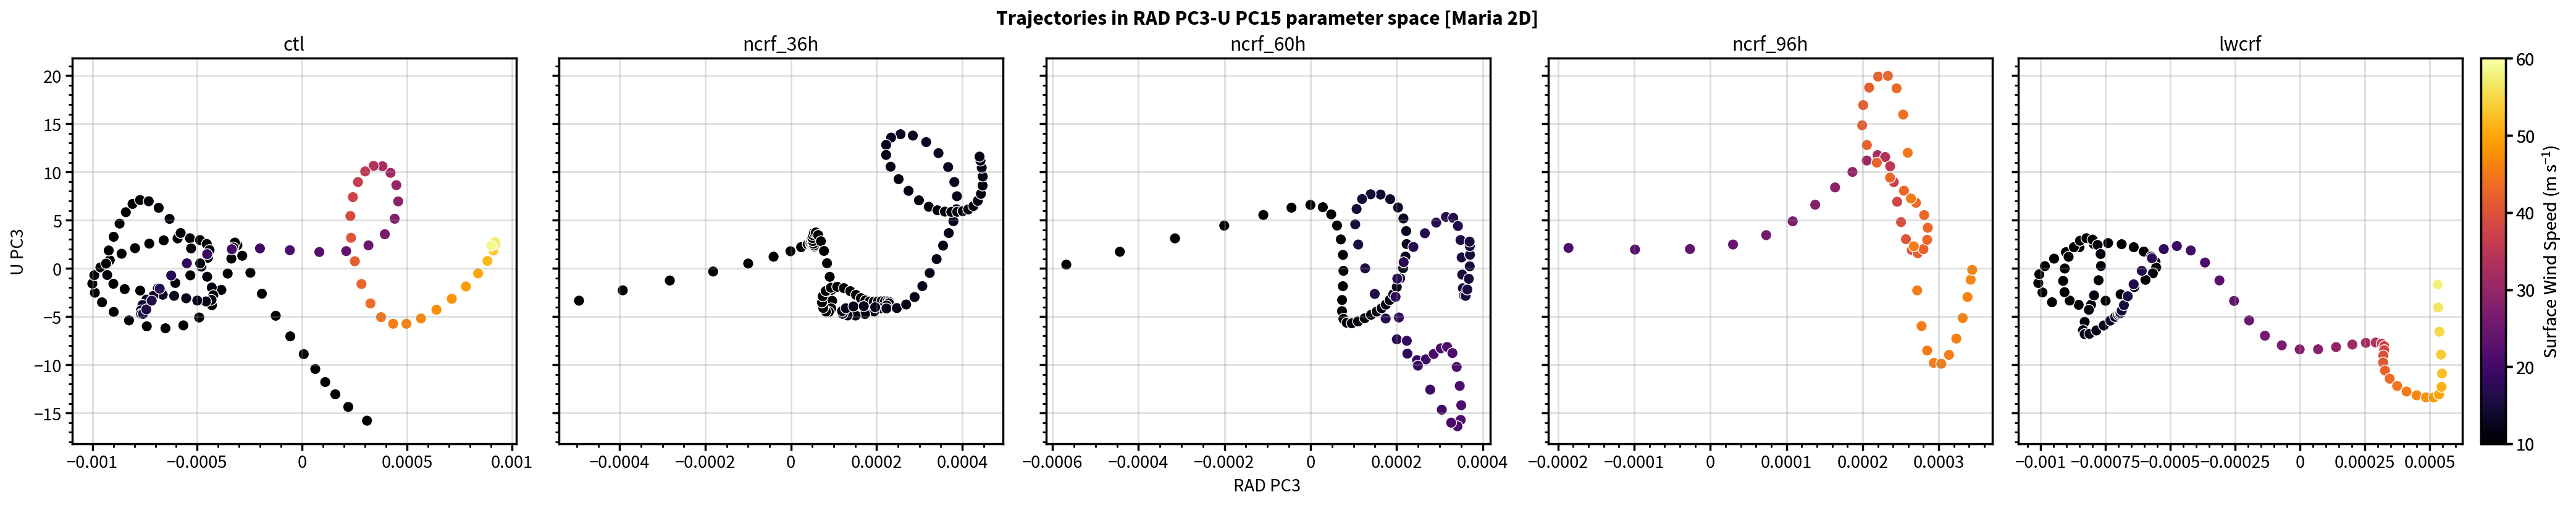

In [41]:
fig,axs = plot.subplots(ncols=5,nrows=1,axwidth=3.595,refaspect=1.1531)
expname=['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf']
ct0 = axs[0].scatter(np.ma.masked_where(maxmeanWSURF[0]>59,(PCtraj_dict['rad'][0][:,2])),np.ma.masked_where(maxmeanWSURF[0]>59,(PCtraj_dict['u'][0][:,14])), 
                         s= 40, c = maxmeanWSURF[0], cmap='inferno',linewidths=0.5, edgecolors='w',vmin=10,vmax=60)
axs[0].format(title=expname[0])
for i in range(1,5):
    axs[i].scatter(np.ma.masked_where(maxmeanWSURF[i]>59,(PCtraj_dict['rad'][i][:,2])),np.ma.masked_where(maxmeanWSURF[i]>59,(PCtraj_dict['u'][i][:,14])), 
                         s= 40, c = maxmeanWSURF[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmin=10,vmax=60) #variance:{(pcex[index[i]]*100):.1f}%'
    axs[i].format(title=expname[i])#,ylim=[-0.015,0.015])
axs.grid(alpha=0.3,color='gray',linewidth=1)
plt.colorbar(ct0,label='Surface Wind Speed (m s$^{-1}$)')
axs.format(ylabel='U PC3',xlabel='RAD PC3',suptitle=r'Trajectories in RAD PC3-U PC15 parameter space [Maria 2D]')#,ylim=[-0.015,0.015])
plt.savefig('../../figures/0727/MARIAintermediate_RADPC_UPC15_traj.png',dpi=300)
plt.show()

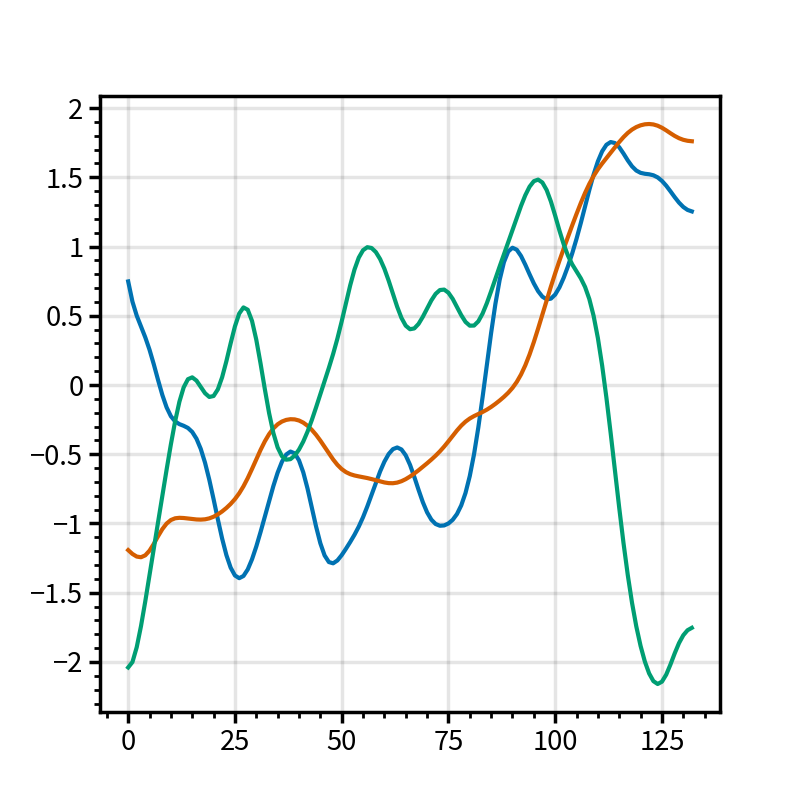

In [43]:
def normalize(array=None):
    return (array-np.nanmean(array))/np.nanstd(array)
plt.plot(normalize(PCRAD[0][:,2]))
plt.plot(normalize(PCV[0][:,8]))
plt.plot(normalize(PCU[0][:,2]))
plt.show()